In [1]:
from collections import namedtuple
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, make_scorer
from pipe import select, where, sort

import presentation as p

# reading in relevant data frames

training_df_scaled_enc_le_clean = pd.read_csv('data/training_df_scaled_enc_le_clean.csv', index_col=None)
training_df_enc_le_clean = pd.read_csv('data/training_df_enc_le_clean.csv', index_col=None)
testing_df_scaled_enc_le_clean = pd.read_csv('data/testing_df_scaled_enc_le_clean.csv', index_col=None)
testing_df_enc_le_clean = pd.read_csv('data/testing_df_enc_le_clean.csv', index_col=None)

# Metrics
beta = 10
fbeta_average = 'weighted'

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.blues_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    #sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.purples_c)
    #plt.title(f'Confusion Matrix for Target "{target}"')
    #plt.xlabel('Predicted label')
    #plt.ylabel('True label')
    #plt.show()

eval_result = namedtuple('EvaluationResult', ['model', 'accuracy', 'fbeta'])

def evaluate_model(model, X_test, y_true, beta=beta, average=fbeta_average, display_false_negatives=False):
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    if display_false_negatives:
        total_attacks = y_true.value_counts().iloc[1]
        confusion = confusion_matrix(y_true, pred)
        false_negatives = confusion[1, 0]
        print(f'False negatives: {false_negatives} ({100 * false_negatives / total_attacks:.3f}% out of {total_attacks} attacks, {100 * false_negatives / len(y_true):.3f}% overall)\n')
    return eval_result(model, acc, fbeta)

# Selecting subsets of the data according to their importance for the models

feature_imp_is_attack = {
    'same_srv_rate': 0.21199866684770505,
    'count': 0.1385794555921013,
    'diff_srv_rate': 0.11660354574720663,
    'src_bytes': 0.07133604504271888,
    'flag': 0.0689813541719748,
    'dst_host_srv_serror_rate': 0.0621598020912925,
    'dst_bytes': 0.057168688956664895,
    'dst_host_same_srv_rate': 0.05254858459557669,
    'srv_serror_rate': 0.04469331875735019,
    'serror_rate': 0.04097324469080398,
    'service': 0.01868051080047695,
    'dst_host_serror_rate': 0.01802081827734208,
    'dst_host_srv_count': 0.011545183650792126,
    'dst_host_same_src_port_rate': 0.011337335403034117,
    'protocol_type': 0.01111283067949643,
    'srv_count': 0.009167672319969513,
    'dst_host_count': 0.00873490361773566,
    'dst_host_srv_rerror_rate': 0.008354143406230159,
    'dst_host_diff_srv_rate': 0.007982036329319523,
    'logged_in': 0.007096409133012435,
    'dst_host_srv_diff_host_rate': 0.006912055417103559,
    'dst_host_rerror_rate': 0.0048513483664072345,
    'rerror_rate': 0.0025784179881967813,
    'wrong_fragment': 0.0020432908004560796,
    'srv_rerror_rate': 0.0016133665984154693,
    'num_compromised': 0.001456082442758954,
    'duration': 0.0013066127485688805,
    'hot': 0.0012589559107352938,
    'srv_diff_host_rate': 0.0006086465735149157,
    'is_guest_login': 0.00013464784144864953,
    'num_root': 4.6925733316063196e-05,
    'num_failed_logins': 4.487859382061017e-05,
    'num_file_creations': 2.0557845839487765e-05,
    'root_shell': 1.7416012225572053e-05,
    'num_access_files': 1.2171215578937403e-05,
    'num_shells': 8.344719212122783e-06,
    'urgent': 4.825536792287678e-06,
    'land': 4.449872331211087e-06,
    'su_attempted': 2.354686052141186e-06,
    'is_host_login': 1.0098642182210754e-07,
    'num_outbound_cmds': 0.0,
}
feature_imp_attack_group = {
    'count': 0.11920650442888907,
    'same_srv_rate': 0.10508972465410206,
    'diff_srv_rate': 0.08778113217680307,
    'serror_rate': 0.06974624054103938,
    'src_bytes': 0.0640681281401352,
    'dst_host_serror_rate': 0.06197018656697434,
    'dst_host_srv_serror_rate': 0.049256820180968386,
    'flag': 0.0491294984749818,
    'srv_serror_rate': 0.04423081413644857,
    'dst_host_srv_count': 0.03069288273419006,
    'dst_host_same_srv_rate': 0.020759103385937262,
    'dst_host_diff_srv_rate': 0.01598050573983522,
    'logged_in': 0.011148092661821485,
    'dst_host_same_src_port_rate': 0.010252432103140747,
    'dst_host_rerror_rate': 0.009870914010633081,
    'dst_bytes': 0.008271947585178354,
    'service': 0.007529789663669806,
    'dst_host_srv_diff_host_rate': 0.006014249598252015,
    'srv_count': 0.005338970005448468,
    'protocol_type': 0.004343821344787647,
    'dst_host_count': 0.003041925901452739,
    'dst_host_srv_rerror_rate': 0.0023676962473431987,
    'rerror_rate': 0.0022699746770110697,
    'srv_rerror_rate': 0.002078234928357929,
    'wrong_fragment': 0.0010900818924401603,
    'duration': 0.0007935300753938383,
    'srv_diff_host_rate': 0.0007000191956692632,
    'num_compromised': 0.0005603127418954962,
    'hot': 0.0005271824283889686,
    'is_guest_login': 0.00014356022382561943,
    'num_failed_logins': 3.086911390714573e-05,
    'num_root': 1.5834502309349034e-05,
    'root_shell': 1.3788709019323287e-05,
    'num_file_creations': 1.3195338230340304e-05,
    'land': 7.80724860591366e-06,
    'num_access_files': 4.715672181492601e-06,
    'num_shells': 2.8059963938124785e-06,
    'urgent': 1.687193322355405e-06,
    'su_attempted': 6.923677716956813e-07,
    'num_outbound_cmds': 0.0,
    'is_host_login': 0.0,
}
def feature(ranking): return ranking[0]
def importance(ranking): return ranking[1]
def top_n_features(n, features):
    return list(
        list(features.items())
        | sort(importance, reverse=True)
        | select(feature)
    )[:n]
def features_above(threshold, features):
    return list(
        list(features.items())
        | where(lambda feature: importance(feature) >= threshold)
        | select(feature)
    )
# 6.8s

In [18]:
from imblearn.under_sampling import EditedNearestNeighbours

sampler = EditedNearestNeighbours(
    sampling_strategy='majority',   # default: 'not minority'
    n_neighbors=3,                  # default: 3
    kind_sel='all',                 # default: 'all' (less conservative, removes more points)
    n_jobs=-1
)

In [19]:
# Preparing the Training and Testing Datasets

# Attack Detection

X_train_is_attack_original = training_df_scaled_enc_le_clean.drop(['target', 'is_attack', 'target_group'], axis=1)
y_train_is_attack_original = training_df_scaled_enc_le_clean.is_attack
X_test_is_attack_original = testing_df_scaled_enc_le_clean.drop(['target', 'is_attack', 'target_group'], axis=1)
y_true_is_attack_original = testing_df_scaled_enc_le_clean.is_attack

X_train_is_attack, y_train_is_attack = sampler.fit_resample(X_train_is_attack_original, y_train_is_attack_original)
X_test_is_attack = X_test_is_attack_original
y_true_is_attack = y_true_is_attack_original

# Attack Classification

X_train_attack_group_original = training_df_enc_le_clean[training_df_enc_le_clean.is_attack].drop(['target', 'is_attack', 'target_group'], axis=1)
y_train_attack_group_original = training_df_enc_le_clean[training_df_enc_le_clean.is_attack].target_group
X_test_attack_group_original = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].drop(['target', 'is_attack', 'target_group'], axis=1)
y_true_attack_group_original = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].target_group

X_train_attack_group, y_train_attack_group = sampler.fit_resample(X_train_attack_group_original, y_train_attack_group_original)
X_test_attack_group = X_test_attack_group_original
y_true_attack_group = y_true_attack_group_original

# 66m 55.7s

In [25]:
model_is_attack = RandomForestClassifier(
    criterion='entropy',
	max_depth=10,
	n_estimators=100,
	n_jobs=-1,
	random_state=404
).fit(X_train_is_attack, y_train_is_attack)
y_pred_is_attack = model_is_attack.predict(X_test_is_attack)
result_is_attack = evaluate_model(model_is_attack, X_test_is_attack, y_true_is_attack, display_false_negatives=True, average='binary')
# 21.1s


-- Testing Results --
Accuracy    on Verification Data:	0.928504
Fbeta scroe on Verification Data:	0.883978

              precision    recall  f1-score   support

       False       0.93      0.96      0.94     47913
        True       0.92      0.88      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.93      0.92      0.92     77291
weighted avg       0.93      0.93      0.93     77291

False negatives: 3420 (11.641% out of 29378 attacks, 4.425% overall)



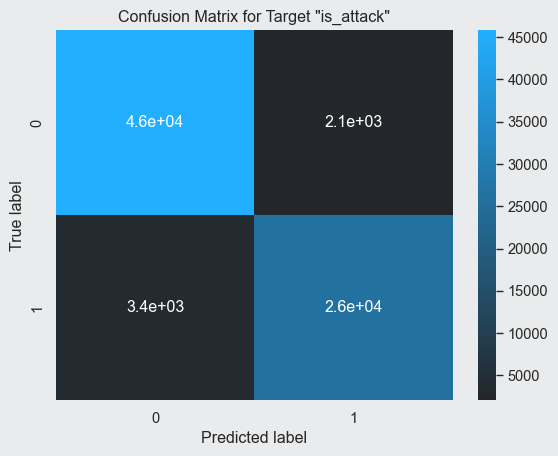

In [26]:
simple_confusion_matrix(y_true_is_attack, y_pred_is_attack, 'is_attack')

In [29]:
model_attack_group = RandomForestClassifier(
	criterion='gini',
	max_depth=20,
	n_estimators=20,
	n_jobs=-1,
	random_state=404
).fit(X_train_attack_group, y_train_attack_group)

In [30]:
y_pred_attack_group = model_attack_group.predict(X_test_attack_group)

In [31]:
result_attack_group = evaluate_model(model_attack_group, X_test_attack_group, y_true_attack_group, average='macro')


-- Testing Results --
Accuracy    on Verification Data:	0.906733
Fbeta scroe on Verification Data:	0.674752

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     23747
           2       0.55      0.84      0.66      3041
           3       0.97      0.56      0.71      2533
           4       0.27      0.35      0.30        57

    accuracy                           0.91     29378
   macro avg       0.69      0.68      0.66     29378
weighted avg       0.93      0.91      0.91     29378



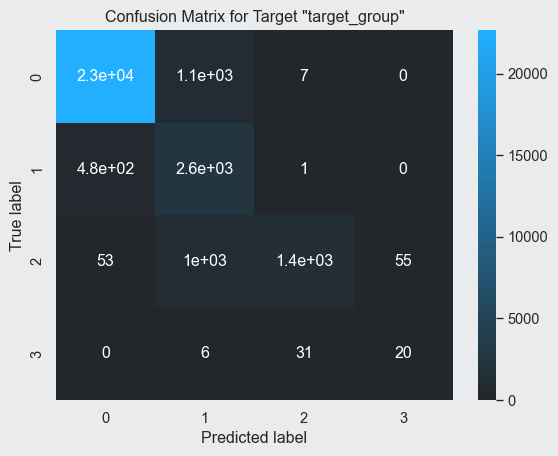

In [32]:
simple_confusion_matrix(y_true_attack_group, y_pred_attack_group, 'target_group')

---

Save the undersampled data for reuse.

In [35]:
columns = training_df_enc_le_clean.drop(['target', 'target_group', 'is_attack'], axis=1).columns

X_train_is_attack_df = pd.DataFrame(X_train_is_attack, columns=columns)
y_train_is_attack_df = pd.Series(y_train_is_attack, name='is_attack')
X_train_attack_group_df = pd.DataFrame(X_train_attack_group, columns=columns)
y_train_attack_group_df = pd.Series(y_train_attack_group, name='target_group')

In [37]:
X_train_is_attack_df.to_csv('data/X_train_is_attack_enn_undersampling.csv', index=False)
y_train_is_attack_df.to_csv('data/y_train_is_attack_enn_undersampling.csv', index=False)
X_train_attack_group_df.to_csv('data/X_train_attack_group_enn_undersampling.csv', index=False)
y_train_attack_group_df.to_csv('data/y_train_attack_group_enn_undersampling.csv', index=False)
# 1m 26.0s